In [1]:
import tensorflow as tf
import os
import hickle as hkl
import numpy as np

In [2]:
%run ../../src/preprocessing/indices.py

In [3]:
predict_model_path = "../../models/feature-extraction/"

In [4]:
predict_graph_def = tf.compat.v1.GraphDef()
if os.path.exists(predict_model_path):
    print(f"Loading model from {predict_model_path}")
    predict_file = tf.io.gfile.GFile(predict_model_path + "predict_graph.pb", 'rb')
    predict_graph_def.ParseFromString(predict_file.read())
    predict_graph = tf.import_graph_def(predict_graph_def, name='predict')
    predict_sess = tf.compat.v1.Session(graph=predict_graph)
    predict_logits = predict_sess.graph.get_tensor_by_name(f"predict/conv2d_13/Sigmoid:0") 
    feature_extraction = predict_sess.graph.get_tensor_by_name(f"predict/csse_out_mul/mul:0")  
    feature_extraction_initial = predict_sess.graph.get_tensor_by_name(
        "predict/conv_median_drop/drop_block2d_1/cond/Merge:0")
    predict_inp = predict_sess.graph.get_tensor_by_name("predict/Placeholder:0")
    predict_length = predict_sess.graph.get_tensor_by_name("predict/PlaceholderWithDefault:0")
else:
    raise Exception(f"The model path {predict_model_path} does not exist")

Loading model from ../../models/feature-extraction/


In [5]:
min_all = [0.006576638437476157, 0.0162050812542916, 0.010040436408026246, 0.013351644159609368, 
           0.01965362020294499, 0.014229037918669413, 0.015289539940489814, 0.011993591210803388, 
           0.008239871824216068, 0.006546120393682765, 0.0, 0.0, 0.0, -0.1409399364817101,
           -0.4973397113668104, -0.09731556326714398, -0.7193834232943873]

max_all = [0.2691233691920348, 0.3740291447318227, 0.5171435111009385, 0.6027466239414053, 
           0.5650263218127718, 0.5747005416952773, 0.5933928435187305, 0.6034943160143434,
           0.7472037842374304, 0.7000076295109483, 0.509269855802243, 0.948334642387533, 
           0.6729257769285485, 0.8177635298774327, 0.35768999002433816, 0.7545951919107605, 0.7602693339366691]

In [6]:
def convert_to_db(x: np.ndarray, min_db: int) -> np.ndarray:
    """ Converts unitless backscatter coefficient
        to db with a min_db lower threshold
        
        Parameters:
         x (np.ndarray): unitless backscatter (T, X, Y, B) array
         min_db (int): integer from -50 to 0
    
        Returns:
         x (np.ndarray): db backscatter (T, X, Y, B) array
    """
    
    x = 10 * np.log10(x + 1/65535)
    x[x < -min_db] = -min_db
    x = (x + min_db) / min_db
    return np.clip(x, 0, 1)

In [7]:
idx = 0

def load_sample(idx):
    s2 = hkl.load(f"../train-s2/{str(idx)}.hkl")
    s2 = np.float32(s2) / 65535
    s1 = hkl.load(f"../train-s1/{str(idx)}.hkl")
    slope = np.load(f"../train-slope/{str(idx)}.npy")
    return s2, s1, slope

def preprocess_sample(s2, s1, slope):
    sample = np.zeros((12, 28, 28, 17))

    sample[..., :10] = s2[..., :10]
    sample[..., 10] = slope[2:-2, 2:-2, 0]
    sample[..., 11:13] = s1[:, 2:-2, 2:-2, :]

    print(f"{idx}.hkl \n"
          f"S2: {s2.shape} \n"
          f"S1: {s1.shape} \n"
          f"Slope: {slope.shape}")
    
    sample[..., 11] = convert_to_db(sample[..., 11], 22)
    sample[..., 12] = convert_to_db(sample[..., 12], 22)

    sample[..., 13] = evi(sample)
    sample[..., 14] = bi(sample)
    sample[..., 15] = msavi2(sample)
    sample[..., 16] = grndvi(sample)

    med = np.median(sample, axis = 0)
    med = med[np.newaxis, :, :, :]
    sample = np.concatenate([sample, med], axis = 0)
    
    for band in range(0, sample.shape[-1]):
        mins = min_all[band]
        maxs = max_all[band]
        sample[..., band] = np.clip(sample[..., band], mins, maxs)
        midrange = (maxs + mins) / 2
        rng = maxs - mins
        standardized = (sample[..., band] - midrange) / (rng / 2)
        sample[..., band] = standardized
    print("Finished data scaling")
    return sample

In [8]:
def multiplot(matrices, nrows = 8, ncols = 4):
    '''Docstring
    
         Parameters:
          matrices (list):
          nrows (int):
          
         Returns:
          None
    '''
    fig, axs = plt.subplots(ncols=4, nrows = nrows)
    fig.set_size_inches(18, 4*nrows)
    to_iter = [[x for x in range(i, i + ncols + 1)] for i in range(0, nrows*ncols, ncols)]
    counter = 0
    for r in range(1, nrows + 1):
        min_i = min(to_iter[r-1])
        max_i = max(to_iter[r-1])
        for i in range(ncols):
            sns.heatmap(data = matrices[0, ..., counter], ax = axs[r - 1, i], cbar = False,
                       cmap = sns.color_palette("viridis", as_cmap=True))
            axs[r - 1, i].set_xlabel("")
            axs[r - 1, i].set_ylabel("")
            axs[r - 1, i].set_yticks([])
            axs[r - 1, i].set_xticks([])
            counter += 1
    plt.show

In [18]:
idx = 230043
s2, s1, slope = load_sample(idx)
sample = preprocess_sample(s2, s1, slope)

batch_x = sample[np.newaxis]
lengths = np.full((batch_x.shape[0]), 12)

preds = predict_sess.run(predict_logits,
                      feed_dict={predict_inp:batch_x, 
                                 predict_length:lengths})

inp_features = predict_sess.run(feature_extraction,
                      feed_dict={predict_inp:batch_x, 
                                 predict_length:lengths})

out_features = predict_sess.run(feature_extraction_initial,
                      feed_dict={predict_inp:batch_x, 
                                 predict_length:lengths})

all_features = np.empty((14, 14, 1+32+32))
all_features[..., 0] = preds.squeeze()
all_features[..., 1:33] = inp_features.squeeze()
all_features[..., 33:] = out_features.squeeze()[7:-7, 7:-7]
hkl.dump(all_features, "train-features/" + str(idx) + ".hkl", mode='w', compression='gzip')

230043.hkl 
S2: (12, 28, 28, 12) 
S1: (12, 32, 32, 2) 
Slope: (32, 32, 1)
Finished data scaling


In [19]:
batch_x = sample[np.newaxis]
lengths = np.full((batch_x.shape[0]), 12)
preds = predict_sess.run(predict_logits,
                      feed_dict={predict_inp:batch_x, 
                                 predict_length:lengths})


<AxesSubplot:>

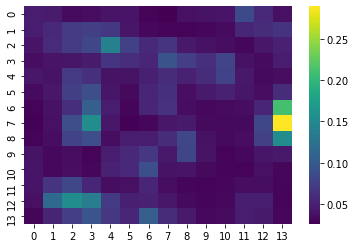

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.heatmap(preds.squeeze(), cmap = sns.color_palette("viridis", as_cmap=True))

In [34]:
batch_x = sample[np.newaxis]
lengths = np.full((batch_x.shape[0]), 12)
preds = predict_sess.run(feature_extraction,
                      feed_dict={predict_inp:batch_x, 
                                 predict_length:lengths})

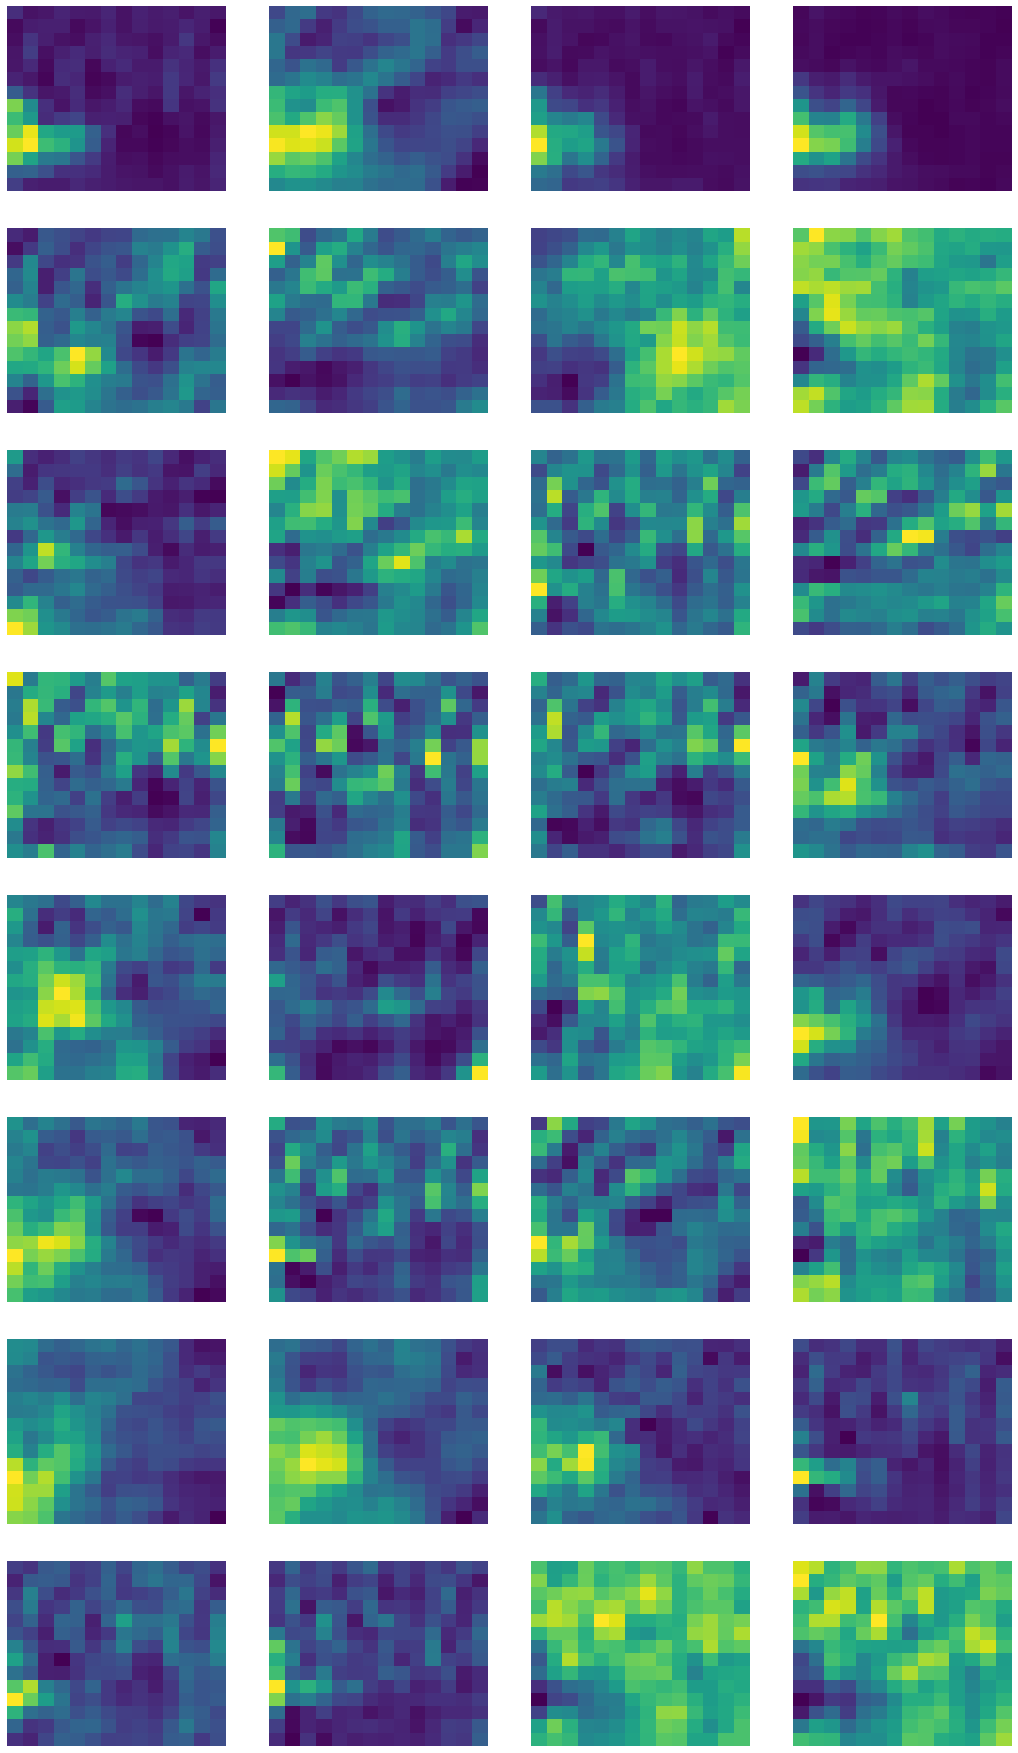

In [35]:
multiplot(preds)

In [36]:
batch_x = sample[np.newaxis]
lengths = np.full((batch_x.shape[0]), 12)
preds = predict_sess.run(feature_extraction_initial,
                      feed_dict={predict_inp:batch_x, 
                                 predict_length:lengths})


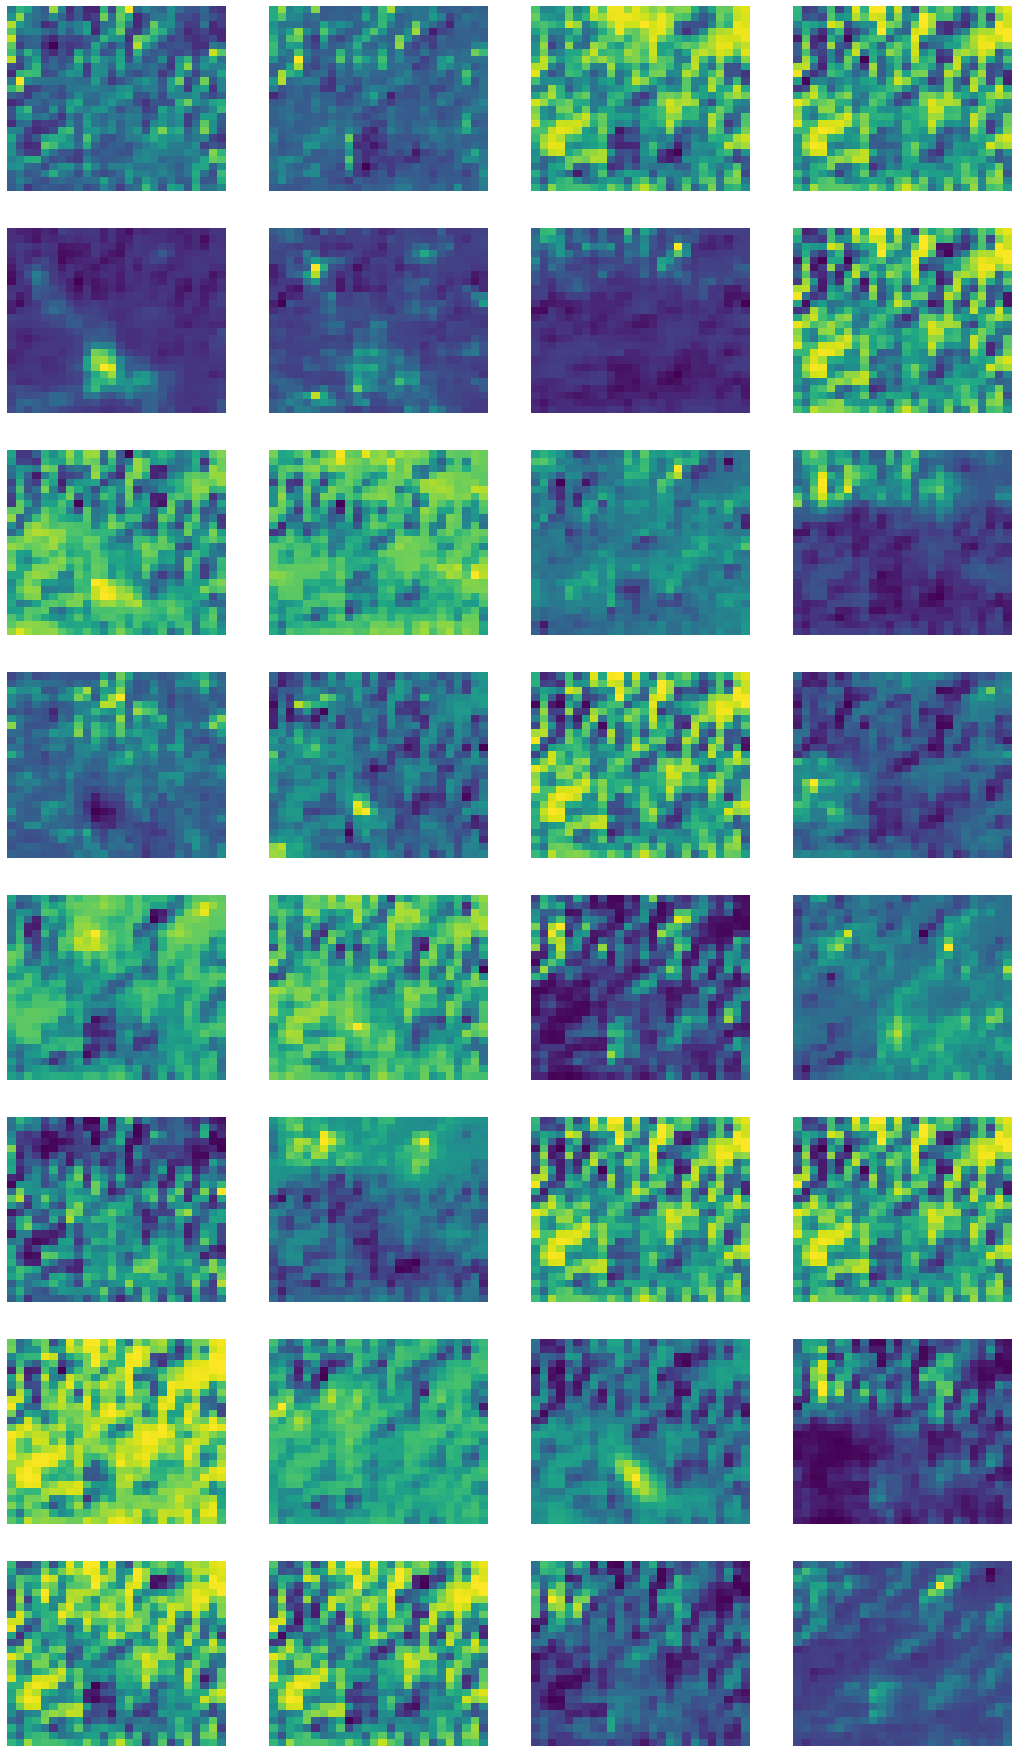

In [37]:
multiplot(preds[:, 1:-1, 1:-1,])